In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


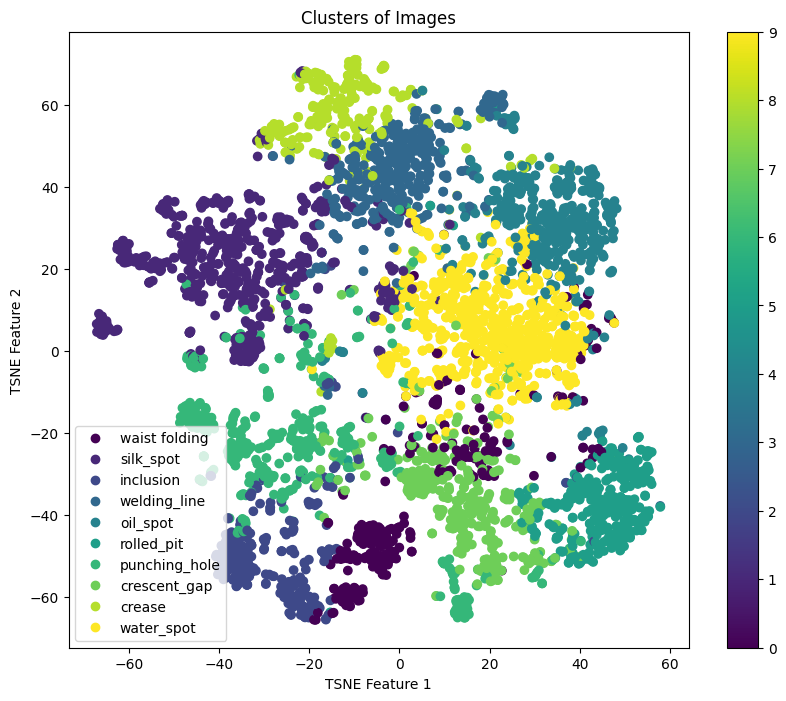

In [ ]:
# Import necessary libraries
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation for data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change image brightness, contrast, etc.
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to load and preprocess images
def load_and_process_images(image_folder, transform, augment_transform):
    processed_images = []
    labels = []
    for label_idx, label_name in enumerate(os.listdir(image_folder)):
        label_folder = os.path.join(image_folder, label_name)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(label_folder, filename)
                    image = Image.open(image_path).convert('RGB')
                    processed_images.append(transform(image))
                    labels.append(label_idx)
                    # Apply augmentation and add augmented image
                    augmented_image = augment_transform(image)
                    processed_images.append(augmented_image)
                    labels.append(label_idx)
    return torch.stack(processed_images), labels



# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the final fully connected layer
model = model.to(device)
model.eval()

# Function to extract features using ResNet-50
def extract_features(images, model, batch_size=32):
    model.eval()
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_images = images[i:i + batch_size].to(device)
            batch_features = model(batch_images).squeeze().cpu().numpy()
            features.append(batch_features)
    return np.vstack(features)

# Function for K-means clustering
def perform_kmeans(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    predicted_labels = kmeans.fit_predict(features)
    return predicted_labels


# Specify image folder containing dataset
image_folder = '/content/drive/MyDrive/Colab Notebooks/Datasets/defects_kaggle'

# Load and preprocess images
processed_images, labels = load_and_process_images(image_folder, transform, augment_transform)
processed_images = processed_images.to(device)

# Extract features using ResNet-50
features = extract_features(processed_images, model)


# Perform K-means clustering on extracted features
num_clusters = len(os.listdir(image_folder))  # Number of clusters based on folder names
predicted_labels = perform_kmeans(features, num_clusters)

# Reduce dimensionality for visualization
pca = PCA(n_components=50)
pca_features = pca.fit_transform(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=predicted_labels, cmap='viridis')
plt.title('Clusters of Images')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=os.listdir(image_folder))
plt.colorbar(scatter)
plt.show()
